In [1]:
using OffsetArrays

In [2]:
function BP_th(H, tus)
    p1 = prod(tus[i][1] for i=1:length(tus))*exp(H)
    p2 = prod(tus[i][2] for i=1:length(tus))*exp(-H)
    if p1+p2==0
        println("conflicting messages in BP_th")
    end
    th1 = p1/(p1+p2)
    th2 = p2/(p1+p2)
    (th1, th2)
end

function BP_tu(s, ths)
    tu1=0.0; tu2=0.0
    for sig in Iterators.product(fill(-1:2:1,2)...)
        ind = [(sig[i]==1 ? 1 : 2) for i=1:length(sig)]
        if prod(sig) == s
            tu1 += prod(ths[i][ind[i]] for i=1:length(ths))
        else
            tu2 += prod(ths[i][ind[i]] for i=1:length(ths))
        end
    end
    (tu1, tu2)
end

BP_tu (generic function with 1 method)

In [3]:
conv(h1::Tuple, h2::Tuple) = tuple(h1[1]*h2[1]+h1[2]*h2[2], h1[1]*h2[2]+h1[2]*h2[1]) 
function BP_th_conv(H, tus)
    th = (exp(H), exp(-H))
    for tu in tus
        th = th.*tu
    end
    th ./ sum(th)
end
function BP_tu_conv(s, ths)
   tu = s==1 ? tuple(1.0,0.0) : tuple(0.0,1.0)
   for i in eachindex(ths)
       tu = conv(tu, ths[i]) 
    end
    tu
end

BP_tu_conv (generic function with 1 method)

In [4]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    i = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        i += 1
        ind = [(sig[j]==1 ? 1 : 2) for j=1:length(sig)]
        σs[i] = sig
        if prod(sig) == s
            @show sig, ind, ths_0[2][ind[2]]
            ν[i] += prod(ths_0[j][ind[j]] for j=1:length(ths_0))
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

In [5]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [6]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        popP_RS = fill((0.5,0.5), 1:popsize),
        popQ_RS = fill((0.5,0.5), 1:popsize),
        q0 = fill(NaN, 1:maxiter)
    )

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    
    @showprogress for t = 1:maxiter
        
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu_conv(s, ths)
        end
        
        q0[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ_RS[ind_tus]
            popP_RS[i] = BP_th_conv(H, tus)
            
            q0[t]+=(popP_RS[i][1]-popP_RS[i][2])^2
        end
        
        q0[t] = q0[t]/length(popP_RS)
    end
    popP_RS, popQ_RS, q0
#    popP_RS, popQ_RS
end

RS (generic function with 1 method)

In [83]:
function init_pop(pop_RS, ϵ)
    pop = fill((NaN, NaN), -1:1, 1:popsize)
    pop[0,:]=popP_RS
    pop[1,:] =fill( ( ϵ, 1-ϵ), 1:popsize)
    pop[-1,:] = fill( ( 1-ϵ, ϵ), 1:popsize)
    pop
end
function init_pop_alternative(pop_RS, ϵ)
    pop = fill((NaN, NaN), -1:1, 1:popsize)
    pop[0,:]=popP_RS
    for i=1:popsize
        pop[1,i]=(rand()<ϵ ? (1.0, 0.0) : pop[0,i])
        pop[-1,i]=(rand()<ϵ ? (0.0, 1.0) : pop[0,i])
    end
    pop
end

init_pop_alternative (generic function with 1 method)

In [63]:
function checkRS(popP)
    q0=0.0; q1=0.0
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        m0 = th[0][1]-th[0][2]; m1 = th[1][1]-th[1][2]; mm1=th[-1][1]-th[-1][2]
        q0 += m0^2
        q1 += m1*th[0][1] - mm1*th[0][2]
    end
    q1= q1/size(popP, 2); q0=q0/size(popP, 2)
    q0, q1, q1-q0
end

checkRS (generic function with 1 method)

In [69]:
function checkHardFields(popP, xmin)
    p1=0.0; pm1=0.0;
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        p1 += (th[1][2] < xmin ? 1.0 : 0.0)
        pm1 += (th[-1][1] < xmin ? 1.0 : 0.0)
    end
    p1=p1/size(popP, 2)
    pm1=pm1/size(popP, 2)
    p1, pm1
end

checkHardFields (generic function with 1 method)

In [122]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        popP = init_pop(popP_RS, 0.95),
        popQ = init_pop(popQ_RS, 0.95),
        q0=fill(NaN, 1:maxiter),
        V=fill(NaN, 1:maxiter),
        p1=fill(NaN, 1:maxiter),
        pm1=fill(NaN, 1:maxiter),
        xmin=10^(-20)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu_conv(s, ths[0,:])
            #@show ind_ths, s
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[1,i] = BP_tu_conv(s, elts)

            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[-1,i] = BP_tu_conv(s, elts)
        end

        q0[t]=0.0; V[t]=0.0; p1[t]=0.0; pm1[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ[:,ind_tus]
            #@show ind_tus
            popP[0,i] = BP_th_conv(H, tus[0,:])
            popP[-1,i] = BP_th_conv(H, tus[-1,:])
            popP[1,i] = BP_th_conv(H, tus[1,:])
            
            m0 = popP[0,i][1]-popP[0,i][2]; m1 = popP[1,i][1]-popP[1,i][2]; mm1 = popP[-1,i][1]-popP[-1,i][2]
            q0[t]+= m0^2
            V[t]+= m1*popP[0,i][1] - mm1*popP[0,i][2]
            p1[t]+=(popP[1,i][2] < xmin ? 1.0 : 0.0)
            pm1[t]+=(popP[-1,i][1] < xmin ? 1.0 : 0.0)
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
        p1[t] = p1[t]/size(popP, 2)
        pm1[t] = pm1[t]/size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V, p1, pm1
end

RSB_entropic_m1 (generic function with 1 method)

Test
---

In [149]:
f3 = 0.3
H=3.0
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
popP_RS

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


10000-element OffsetArray(::Array{Tuple{Float64,Float64},1}, 1:10000) with eltype Tuple{Float64,Float64} with indices 1:10000:
 (0.34186307112722464, 0.6581369288727753)
 (0.1049830508581523, 0.8950169491418477)
 (0.9997002623331286, 0.0002997376668714501)
 (0.99999984602571, 1.5397428989855213e-7)
 (0.9999515768980038, 4.8423101996250076e-5)
 (0.9997909898937524, 0.00020901010624753516)
 (0.5818820323267433, 0.4181179676732566)
 (0.9999769144514069, 2.3085548592991435e-5)
 (0.9999979794868257, 2.020513174404696e-6)
 (0.9993632945449321, 0.0006367054550679245)
 (9.941791533285344e-5, 0.9999005820846673)
 (0.9858260673250502, 0.01417393267494983)
 (0.9034385283252839, 0.09656147167471607)
 ⋮
 (0.9999985631130655, 1.4368869344645584e-6)
 (0.9999969438828855, 3.056117114511355e-6)
 (0.999999953699159, 4.630084102509779e-8)
 (0.9999976810142327, 2.3189857672731273e-6)
 (0.9933082633739119, 0.006691736626088154)
 (0.9999927467872423, 7.253212757666662e-6)
 (0.9999985689340083, 1.43106599168

In [150]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
p1=fill(NaN, 1:maxiter)
pm1=fill(NaN, 1:maxiter)
maxiter=10^3
xmin=10^(-50)
popP, popQ, q0, V, p1, pm1 = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ, xmin=xmin)
popP

Progress: 100%|█████████████████████████████████████████| Time: 0:02:56


3×10000 OffsetArray(::Array{Tuple{Float64,Float64},2}, -1:1, 1:10000) with eltype Tuple{Float64,Float64} with indices -1:1×1:10000:
 (0.999934, 6.55845e-5)  (1.0, 7.23794e-8)   …  (0.998822, 0.00117757)
 (0.999977, 2.33835e-5)  (1.0, 2.92363e-11)     (0.999972, 2.8126e-5)
 (0.999934, 6.55845e-5)  (1.0, 7.23794e-8)      (0.998822, 0.00117757)

In [151]:
checkHardFields(popP, xmin)

(0.0, 0.0)

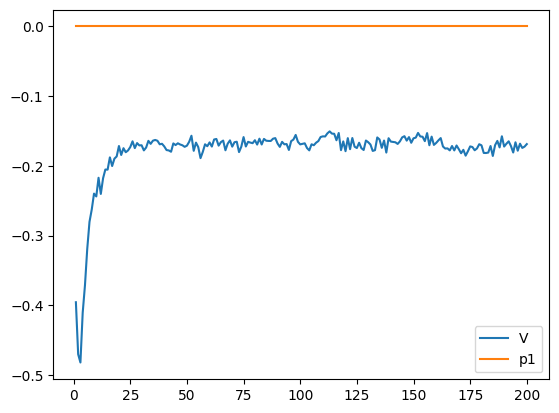

PyObject <matplotlib.legend.Legend object at 0x7f4b36d6be10>

In [152]:
using PyPlot
range = 1:200
plot(range, V[range], label="V")
plot(range, p1[range], label="p1")
legend()